In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
from pandas import set_option
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as md
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sklearn
import statsmodels as stm
import patsy

In [2]:
data = pd.read_csv('data_prepared_almost_continuous.csv', index_col=0)
data.head()

,gps_speed,cTemp,eLoad,iat,imap,rpm,speed,maf,tPos,kpl
0,0.108967,0.363636,0.490119,0.377778,0.013986,0.294648,0.014925,0.014925,0.014925,0.025441
1,0.137183,0.363636,0.482213,0.377778,0.013986,0.294828,0.000000,0.000000,0.000000,0.001042
2,0.143021,0.363636,0.482213,0.377778,0.006993,0.293657,0.000332,0.000332,0.000332,0.001593
3,0.144967,0.376623,0.494071,0.377778,0.013986,0.292755,0.000663,0.000663,0.000663,0.002144
4,0.149831,0.376623,0.474308,0.377778,0.013986,0.294738,0.000995,0.000995,0.000995,0.002695


In [3]:
def feature_subplots(df, title):
    df.plot(subplots=True, layout=(20,1),lw= 1.6,figsize=(16, 24),sharex=True, title=title)

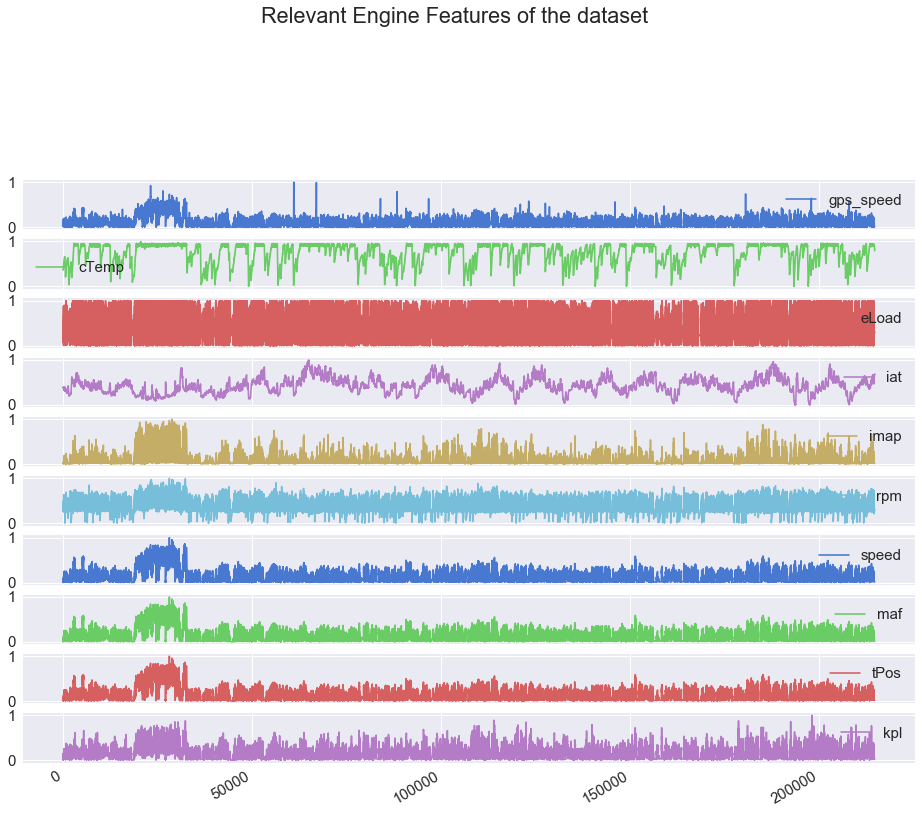

In [4]:
feature_subplots(data,'Relevant Engine Features of the dataset')


# Time series forecast using Keras

In [5]:
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error

from tqdm import trange

Using TensorFlow backend.


In [6]:
# fix random seed for reproducibility
np.random.seed(123)

## Make a forecast for a single timeseries

In [8]:
data.columns

Index(['gps_speed', 'cTemp', 'eLoad', 'iat', 'imap', 'rpm', 'speed', 'maf',
       'tPos', 'kpl'],
      dtype='object')

In [10]:
gps_speed_timeseries = data.drop(['gps_speed', 'cTemp', 'eLoad', 'iat', 'imap', 'rpm', 'speed', 'maf',
       'tPos', 'kpl'], axis = 1)
gps_speed_array = gps_speed_timeseries.values
gps_speed_array = gps_speed_array.astype('float32')

#### 67% of the observations that we can use to train our model, leaving the remaining 33% to test

In [8]:
# split into train and test sets

# split into train and test sets
train_size = int(len(gps_speed_array) * 0.67)
test_size = len(gps_speed_array) - train_size


 The function takes two arguments, the  NumPy array that we want to convert into a dataset and the look_back which is the number of previous time steps to use as input variables to predict the next time period, in this case, defaulted to 1.

This function will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [9]:
train, test = gps_speed_array[0:train_size,:], gps_speed_array[train_size:len(gps_speed_array),:]
print(len(train), len(test))

143843 70849


In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [14]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=2, verbose=2)

Epoch 1/10
 - 57s - loss: 2.0281e-04
Epoch 2/10
 - 61s - loss: 1.2118e-04
Epoch 3/10
 - 57s - loss: 1.2086e-04
Epoch 4/10
 - 59s - loss: 1.2068e-04
Epoch 5/10
 - 59s - loss: 1.2071e-04
Epoch 6/10
 - 60s - loss: 1.2080e-04
Epoch 7/10
 - 56s - loss: 1.2096e-04
Epoch 8/10
 - 59s - loss: 1.2058e-04
Epoch 9/10
 - 58s - loss: 1.2064e-04
Epoch 10/10
 - 50s - loss: 1.2028e-04


In [16]:
# Estimate model performance
import math

trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.01 RMSE)
Test Score: 0.00 MSE (0.01 RMSE)


In [33]:

# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(gps_speed_array)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(gps_speed_array)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(gps_speed_array)-1, :] = testPredict
 


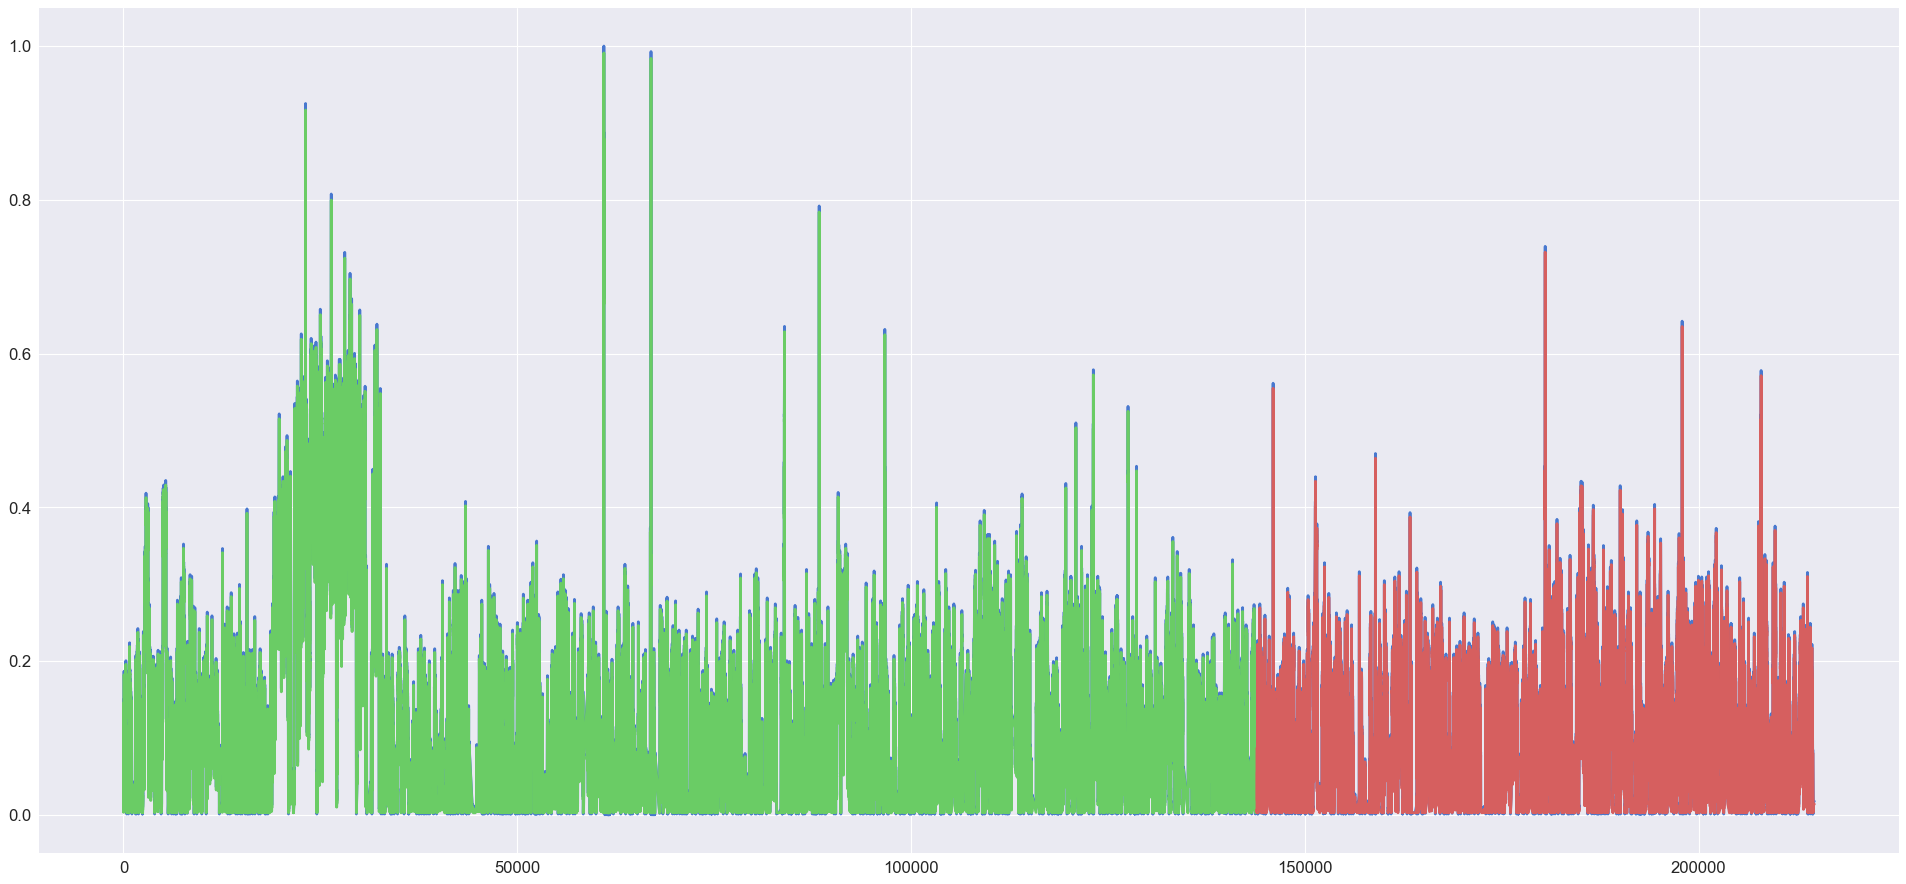

In [57]:
# plot baseline and predictions

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


plt.figure(num=None, figsize=(30, 14), dpi=80, facecolor='w', edgecolor='k')
plt.plot(gps_speed_array,  label="Original")
plt.plot(trainPredictPlot,  label="Training set ")
plt.plot(testPredictPlot,  label="Forecast")

plt.savefig('forecast.png', format = 'png', dpi=300)

plt.show()